In [2]:
from pathlib import Path

from einops import rearrange
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader


%load_ext autoreload
%autoreload 2
from modelZoo.sparseCoding import DyanEncoder
from dataset.crossView_UCLA_ske import NUCLA_CrossView
# import metrics
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')
print(f'Pytorch Version:{torch.__version__} \n{torch.cuda.get_device_name()}')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

Pytorch Version:1.9.1+cu111 
NVIDIA GeForce RTX 2080 Ti


In [3]:
# dyan = Dyan('dyan_config.yaml', 'dir_d_90.pth')
# dyan = Dyan('dyan_config', )

path_list = Path.home().joinpath('data/N-UCLA_MA_3D/data/CV/setup1').as_posix() + '/'
dir = Path().cwd().joinpath('my_tests/final_test/NUCLA_CV_setup1_Single/DIR_D_wiRH/dir_d_100.pth')

file = torch.load(dir, map_location=device)
rr = file['state_dict']['rr']
theta = file['state_dict']['theta']
T = 36
Np = 161
lam=0.001

setup = 'setup1'
dataType = '2D'
sampling = 'Single'
nClip = 1
maskType = 'None'
nw = 8
learning_rate = 1.0e-4
n_epochs = 100
seed = 1337
reweighted = True
freezeD = True
batchsize = 16
workers=8

In [4]:
dyan = DyanEncoder(rr, theta, T, reweighted, lam, device, freezeD)


testSet = NUCLA_CrossView(root_list=path_list, phase='test',
                            setup=setup, dataType=dataType,
                            sampling=sampling, nClip=nClip,
                            T=T, maskType='None')
testloader = DataLoader(testSet, shuffle=False,
                        batch_size=batchsize, num_workers=workers)

In [4]:
# train_views = [sample[0] for sample in trainSet.samples_list]
# print(np.unique(train_views, return_counts=True))

# test_views = [sample for sample in testSet.samples_list]
# print(np.unique(test_views, return_counts=True))
# print(len(test_views))

In [5]:
dyan.eval()
C_ = []

mse = torch.nn.MSELoss()
l1 = torch.nn.L1Loss()

mse

for _, sample in enumerate(testloader):

    skeletons = sample['input_skeletons']['normSkeleton'].float().cuda(device)
    input_skeletons = rearrange(skeletons, 'n c t j d -> (n c) t (j d)')

    sparse_code_test, D, output_skeletons = dyan(input_skeletons)
    C_.append(sparse_code_test.cpu())

# for i in range(len(C_)):
#     print(C_[i].shape)

(29, 16, 161, 50)
(161, 23200)


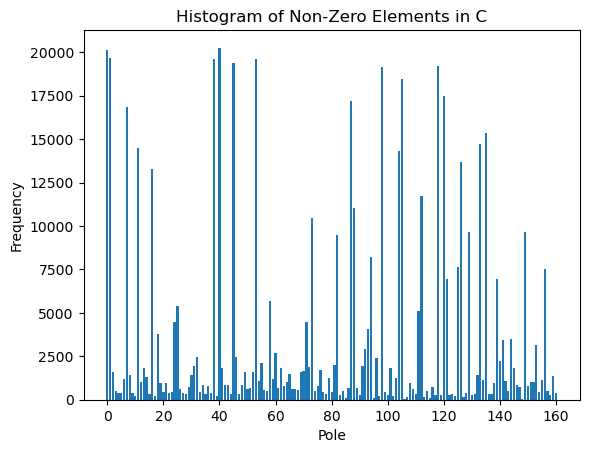

[20115 19670 1581 505 392 363 1177 16842 1441 368 237 14504 1034 1845 1303
 318 13302 212 3778 978 451 990 393 451 4452 5409 604 361 331 748 1407
 1928 2475 423 834 321 808 402 19629 239 20267 1843 841 829 312 19415 2441
 348 841 1624 616 659 1606 19596 1052 2100 533 499 5688 1184 2690 677 1839
 796 1048 1509 643 624 560 1595 1635 4482 1863 10435 512 790 1725 451 349
 1270 432 1997 9488 244 481 114 657 17224 11064 677 254 1948 2942 4052
 8208 121 2378 220 19152 454 266 1842 189 1237 14349 18449 24 136 959 604
 346 5095 11708 172 508 87 713 271 19225 247 17474 6954 265 358 203 7668
 13676 141 394 9675 289 325 1429 14724 1128 15359 329 321 956 6929 2218
 3438 1057 507 3524 1841 865 757 28 9638 767 1045 1030 3174 462 1135 7516
 479 283 1341 411]


In [ ]:

# Convert list C to a numpy array
C_ = np.asanyarray(C_)
print(C_.shape)
C = rearrange(C_, 'b b1 h w -> h (b b1 w)') # stack all vectors horizontally
print(C.shape)

num_vectors = C.shape[1]
# thr = 0.02233575
# thr = 0.03350363
# thr = 0.00498886
thr = (0.00498886 + 0.00997772)/2
C_m = np.ma.masked_less(C, thr, copy=True)


# nz_counts = rearrange(np.count_nonzero(C_m, axis=1))
nz_counts = np.count_nonzero(C_m, axis=1)

# nz_m = np.repeat(nz_counts, num_vectors)
# print(nz_m.shape)



# Create a histogram of the non-zero elements
plt.bar(range(Np), nz_counts)
plt.xlabel('Pole')
plt.ylabel('Frequency')
plt.title('Histogram of Non-Zero Elements in C')
plt.show()
print(nz_counts)


In [34]:
thr = 0.03350363

C_t = torch.Tensor(C)
# C_t  = C_t.view(-1).squeeze()
print(C_t.shape)
mask = C_t.ge(thr)



C_mt = torch.tensor(0)
print(C_mt.dim())
# torch.masked_select(C_t, mask, out=C_mt)
C_mt = torch.masked_fill(C_t, ~mask, 0)
# display(pd.DataFrame(C_mt))

torch.Size([161, 23200])
0


In [38]:
(0.00498886 + 0.00997772)/2

0.00748329

(array([3.524097e+06, 1.016990e+05, 4.782800e+04, 3.126400e+04,
        1.799700e+04, 6.519000e+03, 2.088000e+03, 3.472000e+03,
        2.150000e+02, 2.100000e+01]),
 array([0.        , 0.02476331, 0.04952662, 0.07428993, 0.09905325,
        0.12381656, 0.14857987, 0.17334318, 0.1981065 , 0.2228698 ,
        0.24763311]),
 <BarContainer object of 10 artists>)

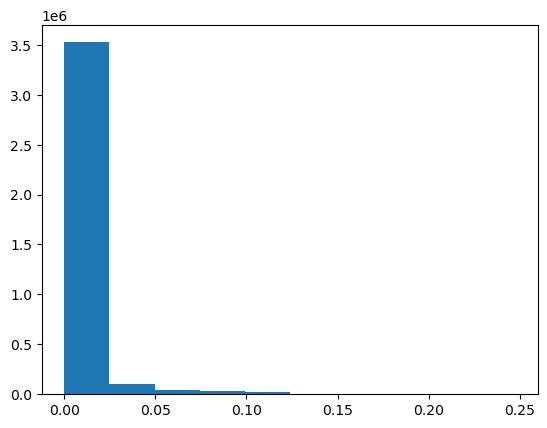

In [20]:
C2 = np.power(C, 2)
C_abs = np.abs(C)
plt.hist(C_abs.reshape(-1))

In [ ]:
display(pd.DataFrame(nonlocal))

0.0051833782

In [ ]:
nz_counts = np.count_nonzero(C, axis=1)
23200

In [24]:
torch.linalg.vector_norm(torch.Tensor(C), dim=0, keepdim=True).shape

torch.Size([1, 23200])

In [19]:
np.sum(C==0) / (161*23200)

0.043517080745341614

In [21]:
display(pd.DataFrame(C))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,22950,22951,22952,22953,22954,22955,22956,22957,22958,22959,22960,22961,22962,22963,22964,22965,22966,22967,22968,22969,22970,22971,22972,22973,22974,22975,22976,22977,22978,22979,22980,22981,22982,22983,22984,22985,22986,22987,22988,22989,22990,22991,22992,22993,22994,22995,22996,22997,22998,22999,23000,23001,23002,23003,23004,23005,23006,23007,23008,23009,23010,23011,23012,23013,23014,23015,23016,23017,23018,23019,23020,23021,23022,23023,23024,23025,23026,23027,23028,23029,23030,23031,23032,23033,23034,23035,23036,23037,23038,23039,23040,23041,23042,23043,23044,23045,23046,23047,23048,23049,23050,23051,23052,23053,23054,23055,23056,23057,23058,23059,23060,23061,23062,23063,23064,23065,23066,23067,23068,23069,23070,23071,23072,23073,23074,23075,23076,23077,23078,23079,23080,23081,23082,23083,23084,23085,23086,23087,23088,23089,23090,23091,23092,23093,23094,23095,23096,23097,23098,23099,23100,23101,23102,23103,23104,23105,23106,23107,23108,23109,23110,23111,23112,23113,23114,23115,23116,23117,23118,23119,23120,23121,23122,23123,23124,23125,23126,23127,23128,23129,23130,23131,23132,23133,23134,23135,23136,23137,23138,23139,23140,23141,23142,23143,23144,23145,23146,23147,23148,23149,23150,23151,23152,23153,23154,23155,23156,23157,23158,23159,23160,23161,23162,23163,23164,23165,23166,23167,23168,23169,23170,23171,23172,23173,23174,23175,23176,23177,23178,23179,23180,23181,23182,23183,23184,23185,23186,23187,23188,23189,23190,23191,23192,23193,23194,23195,23196,23197,23198,23199
0,0.115908,0.006114,0.080608,0.021976,0.056231,0.020395,0.062963,0.048194,0.086355,0.056862,0.101954,0.022657,0.079180,0.029353,0.065796,0.034846,0.063838,0.072236,0.043507,0.072113,3.087790e-02,0.106278,0.015811,0.097543,0.083143,0.071682,0.072019,1.037737e-01,0.057542,0.089404,0.107674,0.002362,0.073409,1.176339e-03,0.081859,0.002739,0.031558,2.336540e-03,0.091854,0.095735,0.091943,0.094147,0.052617,0.094042,0.046931,0.101905,0.034966,0.102871,1.358182e-03,0.099815,0.074719,1.996571e-03,0.045874,1.842364e-02,-7.211260e-03,0.022681,0.022532,0.045856,0.101043,3.909852e-02,9.764659e-02,0.016172,0.139348,0.037027,0.078005,0.046293,0.065324,0.064483,0.030093,0.065058,2.305193e-02,0.102002,0.028009,0.129112,0.102522,0.064052,0.107504,0.097374,0.091358,0.124558,0.059847,2.162426e-04,0.103437,0.0,0.021038,1.402518e-03,0.0,0.0,0.140287,0.132307,0.141519,0.127748,0.071541,0.125847,0.060854,0.136335,0.031068,0.137501,0.017794,0.132817,0.067794,2.169796e-03,0.055460,0.020088,0.010070,0.021695,0.045947,0.044399,0.108855,0.040785,0.093476,0.017626,0.133076,0.038378,0.070330,0.038342,0.059920,0.065848,0.032445,0.065801,0.026300,0.101932,0.006139,0.129513,0.083376,6.566790e-02,0.078084,0.096243,0.068415,0.123207,0.054337,2.337452e-04,0.073644,3.276122e-05,0.032276,0.001761,0.098684,0.001154,0.109268,0.130028,0.109361,0.126223,0.059601,0.124191,0.051039,0.132524,0.029251,0.133076,0.000261,0.133149,0.112061,0.003888,0.101718,0.020034,0.073643,0.019767,0.064582,0.047619,0.068992,0.067429,0.130757,2.087389e-02,0.037298,0.016008,0.047282,0.024901,0.091052,6.232178e-02,0.071294,0.061872,0.045032,0.

In [8]:
mean = np.sum(C, axis=0) / nz_counts
list_vec = [C[:,i] for i in range(Np)]
nz_vals = [vector[vector != 0] for vector in list_vec]
dev2 = [np.power(vals - mean[i], 2) for i, vals in enumerate(nz_vals)]
var = [np.sum(vals) / nz_counts[i] for i, vals in enumerate(dev2)]
stddev = np.sqrt(var)

ValueError: operands could not be broadcast together with shapes (23200,) (161,) 

In [ ]:
good_poles = nz_counts > 200
mask = ~np.tile(good_poles, [dyan.T]).reshape(dyan.T, dyan.Np)
metrics.nice_display(mask)

In [ ]:
masked_dictionary = np.ma.array(dyan.dictionary,mask=mask)
metrics.nice_display(masked_dictionary)

In [5]:
D = torch.Tensor(dyan.dictionary)
DtD = torch.matmul(D.T, D)

# Compute the spectral norm of D
U, S, V = torch.svd(D)
specnorm_D = torch.max(S)

# Compute the singular values of DtD
U_DtD, S_DtD, V_DtD = torch.svd(DtD)
max_singular_value_DtD = torch.max(S_DtD)

# The largest singular value of DtD should be the square of the largest singular value of D
expected_max_singular_value_DtD = specnorm_D ** 2

# Define a tolerance
tolerance = 1e-5

print(f"Spectral Norm of D: {specnorm_D}")
print(f"Max Singular Value of DtD: {max_singular_value_DtD}")
print(f"Expected Max Singular Value of DtD (computed from D): {expected_max_singular_value_DtD}")
print(f"Are they equal within tolerance? {torch.allclose(max_singular_value_DtD, expected_max_singular_value_DtD, atol=tolerance)}")

Spectral Norm of D: 13.260106086730957
Max Singular Value of DtD: 175.83042907714844
Expected Max Singular Value of DtD (computed from D): 175.83041381835938
Are they equal within tolerance? True


In [10]:
torch.linalg.matrix_norm(DtD,2)

tensor(175.8304)